In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/
%ls

/gdrive/MyDrive
 AuroregressiveForecasting/            IncpetionFtAugWeighModel1/
 AuroregressiveForecasting48/          IncpetionFtAugWeighModel1_more_layer/
 AuroregressiveLOUGATTForecasting48/   IncpetionFtModel1/
 AuroregressivePREATTForecasting48/    IncpetionModel1/
'Colab Notebooks'/                     model_plot.png
 Cruchorecasting/                      model.png
 Dataset/                              S3CRET/
'Domande deep learning.gdoc'           SimpleLSTMForecasting/
 FinalModel/                           SimplerModel/
 Gabriele/                             StandardModel/
 IncpetionFtAugModel1/                 training/


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [6]:
def inspect_dataframe(df, columns, zoom):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col][1:zoom])
        axs[i].set_title(col)
    plt.show()


In [7]:
VALIDATION_SPLIT = 0.1

In [8]:
val_size = int(len(dataset)*VALIDATION_SPLIT)
X_train_raw = dataset.iloc[:-val_size]
X_val_raw = dataset.iloc[-val_size:]
print(X_train_raw.shape, X_val_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()
print(X_min)
print(X_max)

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_val_raw-X_min)/(X_max-X_min)

(61676, 7) (6852, 7)
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [9]:
def build_sequences(df, target_labels, window=2000, stride=20, telescope=864): #1156/4 = 288 time-steps into the future
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [10]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [11]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm_layer = tf.keras.layers.LSTM(128, return_sequences=True)(input_layer)

    lstm_layer = tf.keras.layers.LSTM(64, return_sequences=True)(lstm_layer)

    lstm_layer = tf.keras.layers.LSTM(32, return_sequences=False)(lstm_layer)
    # Shape => [batch, out_steps*features].
    lstm_layer = tf.keras.layers.Dense(TELESCOPE*7,
                          kernel_initializer=tf.initializers.zeros())(lstm_layer)
    # Shape => [batch, out_steps, features].
    output_layer = tf.keras.layers.Reshape([TELESCOPE, 7])(lstm_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Return the model
    return model

In [12]:
target_labels = dataset.columns

In [13]:
TELESCOPE = 48
WINDOWS_LENGTH = 288
STRIDE = 9
REG_TELESCOPE = 864/TELESCOPE

In [14]:
X_train, y_train = build_sequences(X_train_raw, target_labels, WINDOWS_LENGTH, STRIDE, TELESCOPE)
X_test, y_test = build_sequences(X_test_raw, target_labels, WINDOWS_LENGTH, STRIDE, TELESCOPE)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6843, 288, 7), (6843, 48, 7), (731, 288, 7), (731, 48, 7))

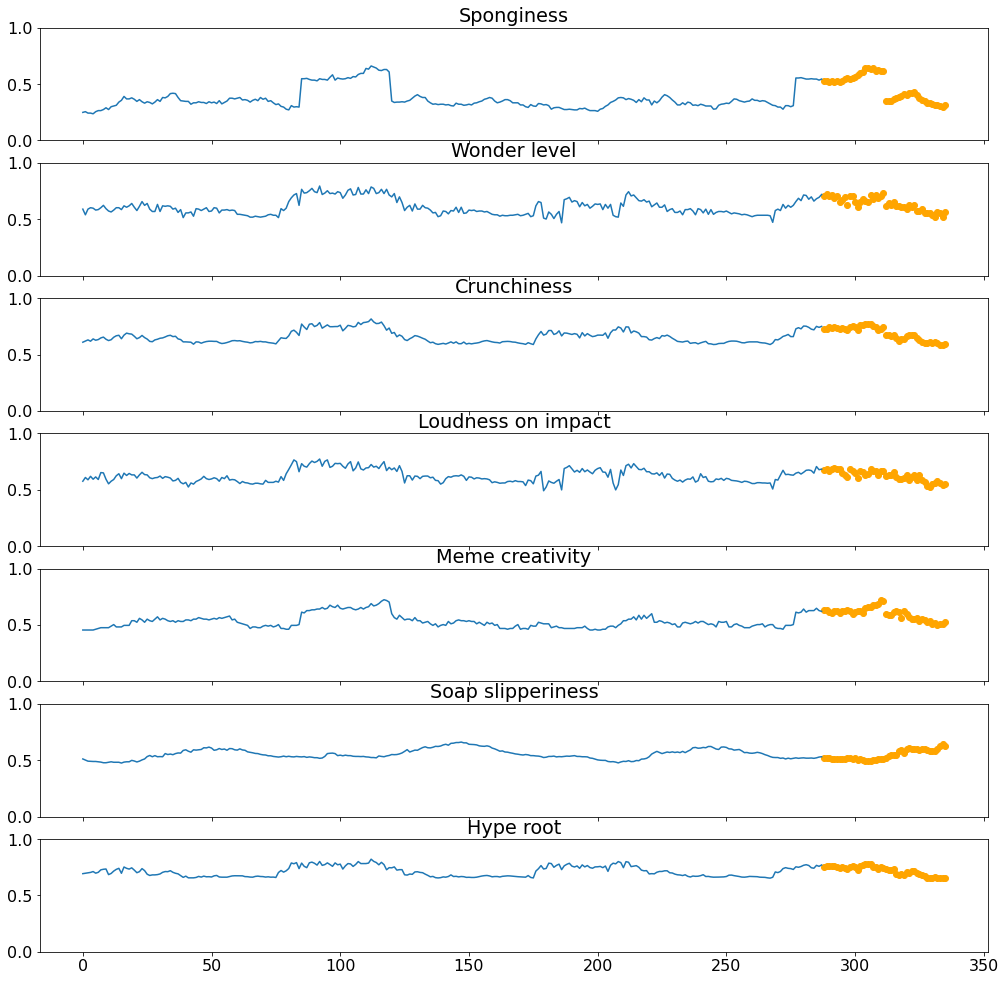

In [15]:
inspect_multivariate(X_train, y_train, target_labels, TELESCOPE)

In [16]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 576, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 576, 128)          69632     
                                                                 
 lstm_1 (LSTM)               (None, 576, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 336)               11088     
                                                                 
 reshape (Reshape)           (None, 48, 7)             0         
                                                                 
Total params: 142,544
Trainable params: 142,544
Non-trainable

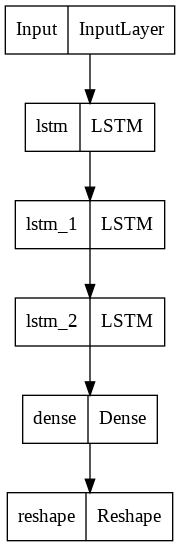

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
97/97 [==============================] - 44s 375ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517 - lr: 0.0010
Epoch 2/200
97/97 [==============================] - 35s 363ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1465 - lr: 0.0010
Epoch 3/200
97/97 [==============================] - 35s 363ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1478 - lr: 0.0010
Epoch 4/200
97/97 [==============================] - 35s 363ms/step - loss: 0.0205 - root_mean_squared_error: 0.1433 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504 - lr: 0.0010
Epoch 5/200
97/97 [==============================] - 35s 363ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1463 - lr: 0.0010
Epoch 6/200
97/97 [==============================] - 35s 364ms/st

KeyboardInterrupt: ignored

In [ ]:
model.save('AuroregressiveForecasting48')

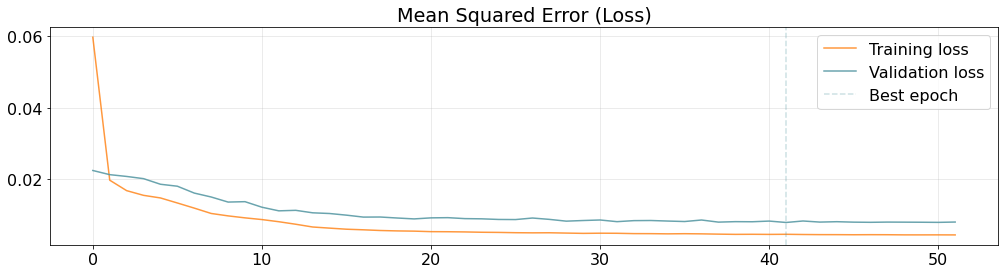

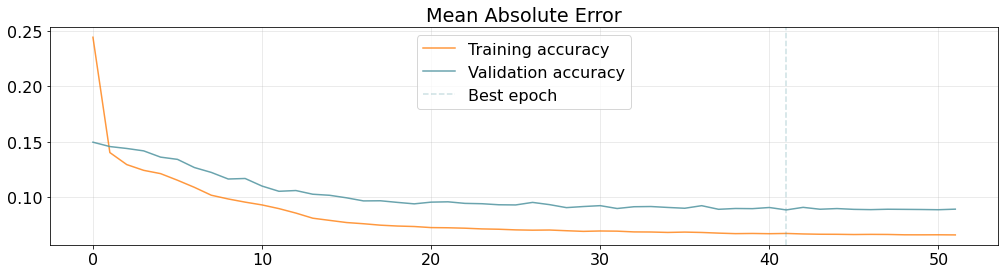

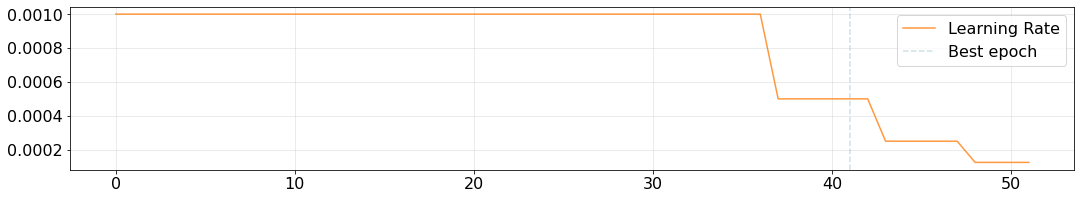

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['root_mean_squared_error'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_root_mean_squared_error'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# model.save('AuroregressiveForecasting')
model = tfk.models.load_model('AuroregressiveForecasting48')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
root_mean_squared_error = math.sqrt(tfk.metrics.mse(y_test.flatten(),predictions.flatten()))
mean_squared_error, mean_absolute_error, root_mean_squared_error

(731, 48, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.008285716>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.064940535>,
 0.09102590936669086)

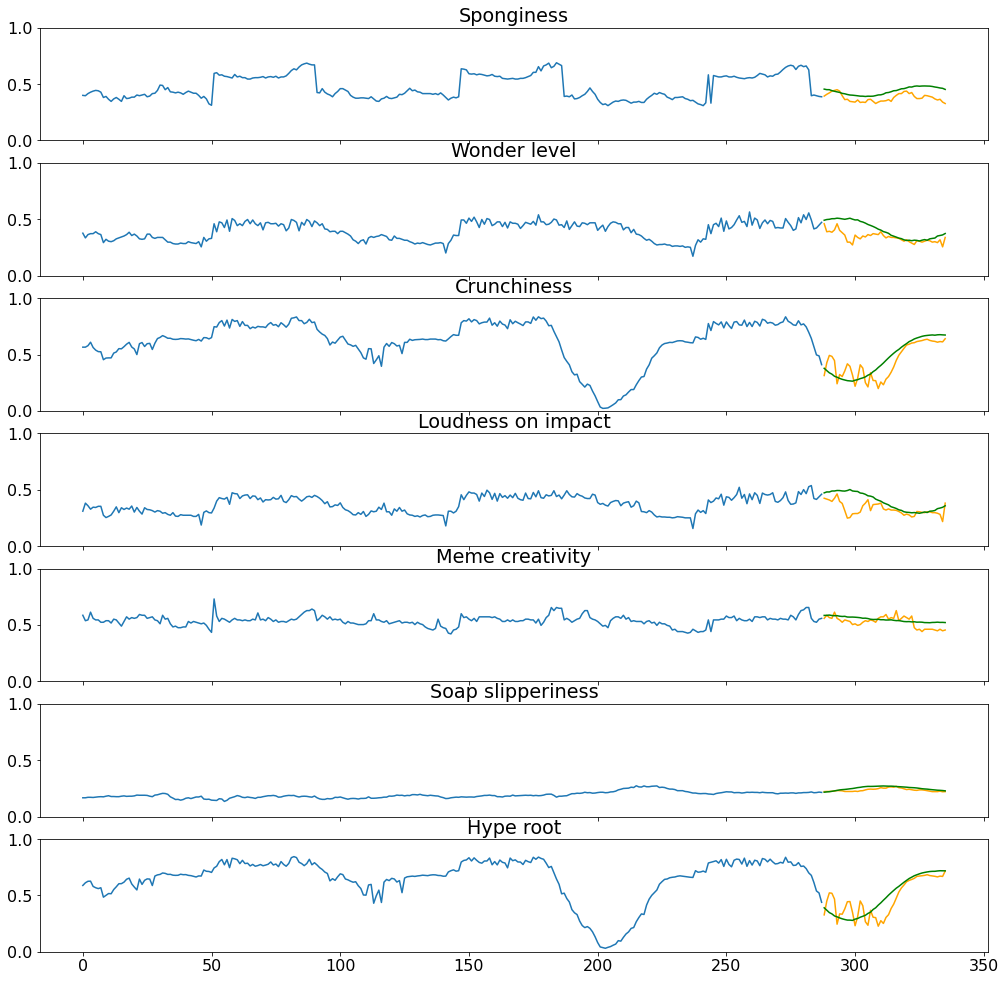

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, TELESCOPE)

In [ ]:
REG_TELESCOPE = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, WINDOWS_LENGTH,TELESCOPE, REG_TELESCOPE)
X_test_reg.shape, y_test_reg.shape

((124, 96, 7), (124, 864, 7))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,REG_TELESCOPE,TELESCOPE):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,TELESCOPE:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(120, 864, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
root_mean_squared_error = math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.012151339>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.082301356>,
 0.11023311249965034)

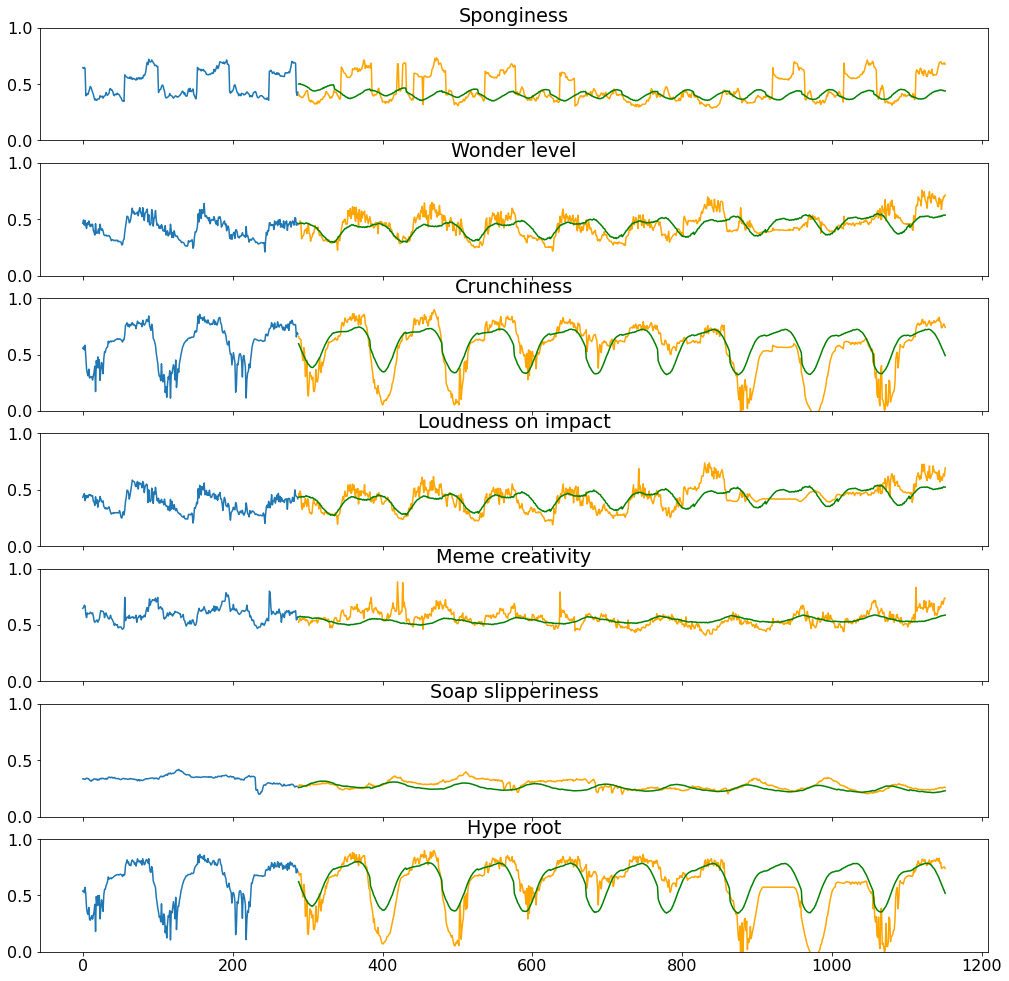

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, REG_TELESCOPE)

predict the future

In [ ]:
future = dataset[-WINDOWS_LENGTH:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 288, 7)

In [ ]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
reg_future = np.array([])
X_temp = future
for reg in range(0, REG_TELESCOPE,TELESCOPE):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,TELESCOPE:,:],pred_temp), axis=1)

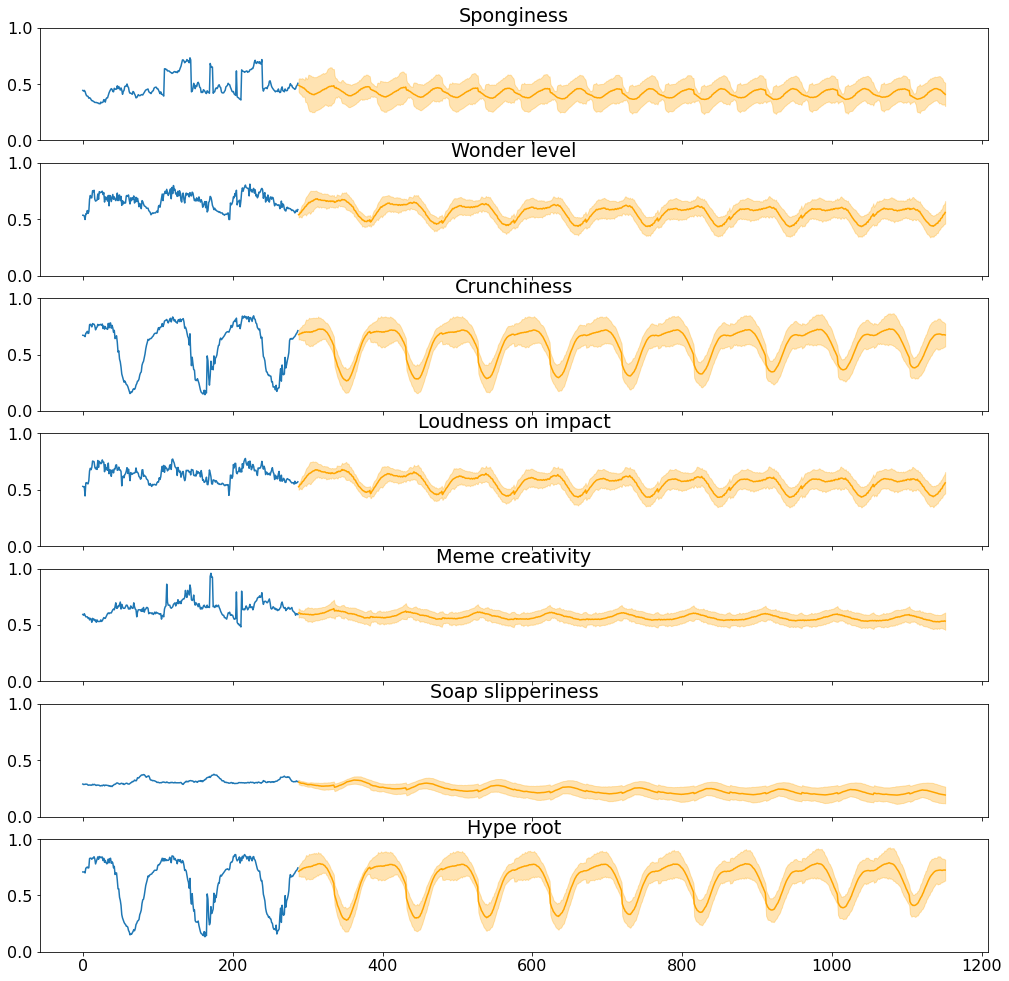

In [ ]:

figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+REG_TELESCOPE), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+REG_TELESCOPE), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

In [17]:
input_train = tfkl.Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = tfkl.Input(shape=(y_train.shape[1], y_train.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 288, 7), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 48, 7), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
def build_att_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    #input_layer = tfkl.Input(shape=input_shape, name='Input')

    
    encoder_last_h1, encoder_last_h2, encoder_last_c = tfkl.LSTM(
    128, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_shape)

    encoder_last_h1 = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = tfkl.BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder = tfkl.RepeatVector(output_train.shape[1])(encoder_last_h1)
    decoder = tfkl.LSTM(128, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

    out = tfkl.TimeDistributed(tfkl.Dense(output_train.shape[2]))(decoder)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_train, outputs=out)
    opt = tfk.optimizers.Adam(lr=0.01, clipnorm=1)
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()


    # Return the model
    return model


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 7)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        69632       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 128)         512         ['lstm[0][0]']                   
 alization)                                                                                   

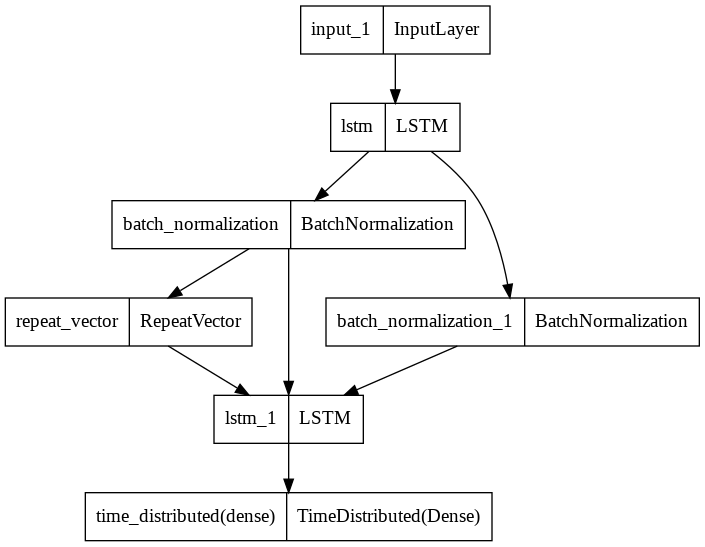

In [ ]:
model = build_att_model(input_train, output_train)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

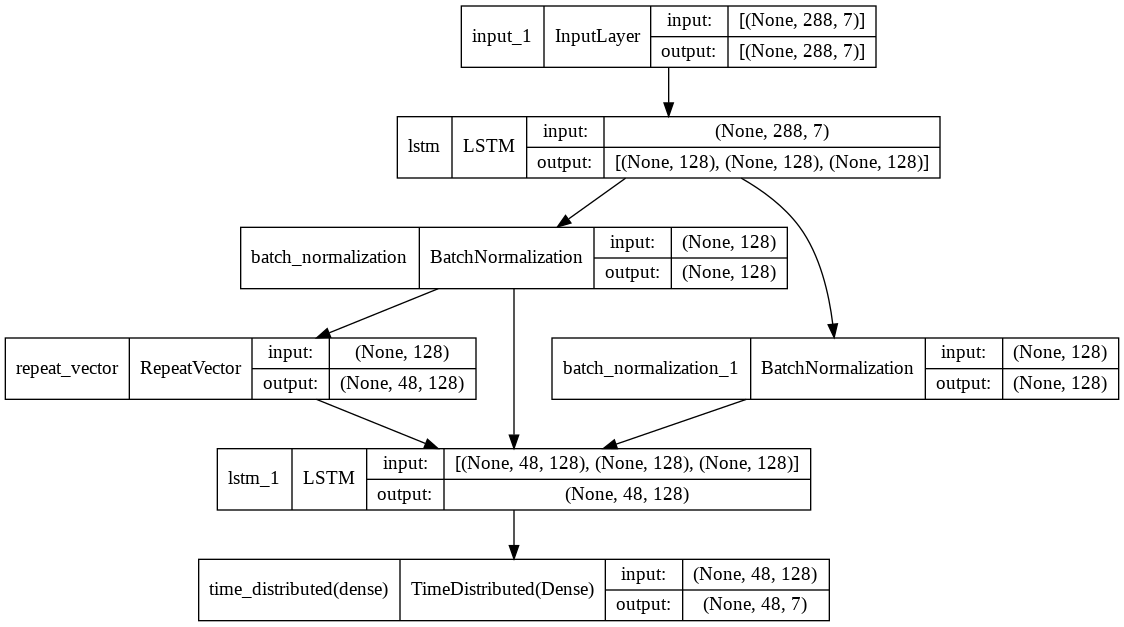

In [ ]:
tfk.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 90,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/90
97/97 [==============================] - 161s 2s/step - loss: 0.0524 - root_mean_squared_error: 0.2288 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1291 - lr: 0.0010
Epoch 2/90
97/97 [==============================] - 153s 2s/step - loss: 0.0150 - root_mean_squared_error: 0.1223 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201 - lr: 0.0010
Epoch 3/90
97/97 [==============================] - 153s 2s/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183 - lr: 0.0010
Epoch 4/90
97/97 [==============================] - 154s 2s/step - loss: 0.0114 - root_mean_squared_error: 0.1070 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176 - lr: 0.0010
Epoch 5/90
97/97 [==============================] - 154s 2s/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159 - lr: 0.0010
Epoch 6/90
97/97 [==============================] - 152s 2s/step - loss: 0.0103 

In [ ]:
model.save('AuroregressivePREATTForecasting48')
model = 

In [18]:
# model.save('AuroregressiveForecasting')
model = tfk.models.load_model('AuroregressivePREATTForecasting48')

In [19]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
root_mean_squared_error = math.sqrt(tfk.metrics.mse(y_test.flatten(),predictions.flatten()))
mean_squared_error, mean_absolute_error, root_mean_squared_error

(731, 48, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.008055311>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06373082>,
 0.08975138269889467)

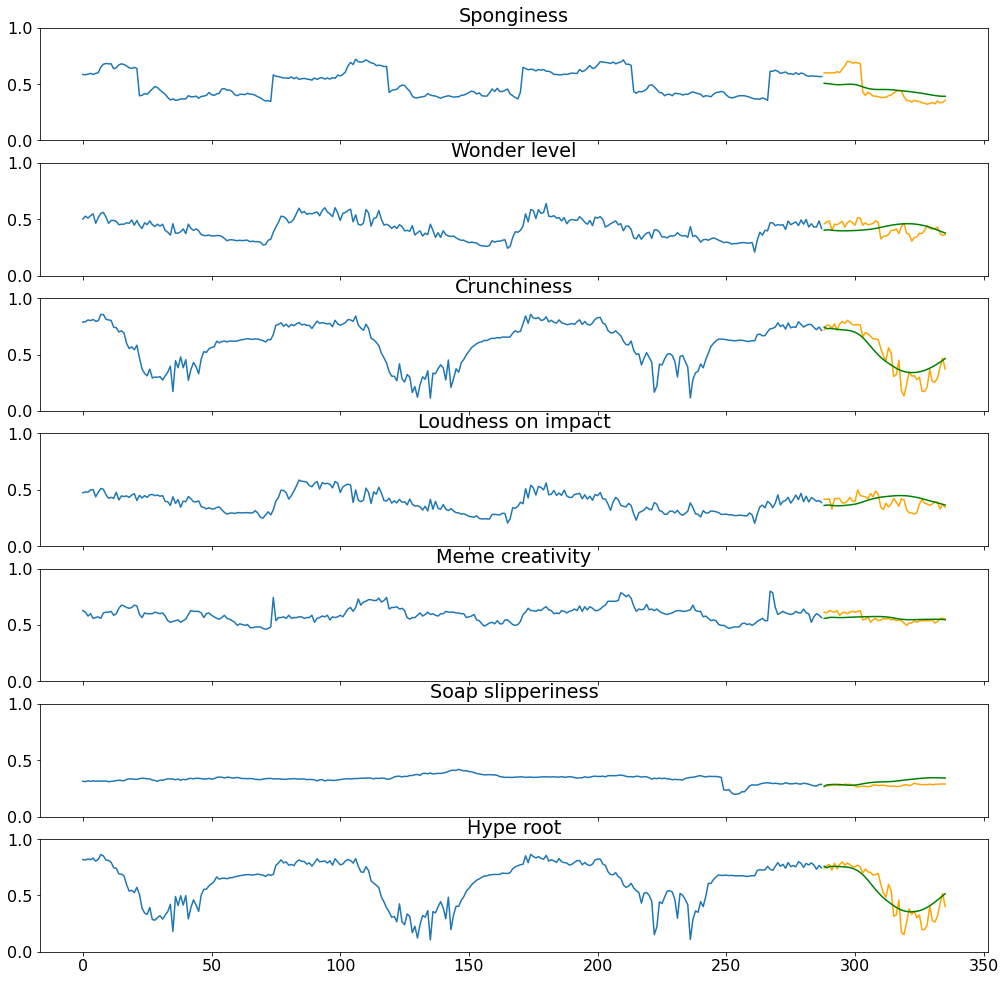

In [20]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, TELESCOPE)

In [21]:
REG_TELESCOPE = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, WINDOWS_LENGTH,TELESCOPE, REG_TELESCOPE)
X_test_reg.shape, y_test_reg.shape

((120, 288, 7), (120, 864, 7))

In [22]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,REG_TELESCOPE,TELESCOPE):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,TELESCOPE:,:],pred_temp), axis=1)

In [23]:
reg_predictions.shape

(120, 864, 7)

In [24]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
root_mean_squared_error = math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.01298113>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08481042>,
 0.11393476120225136)

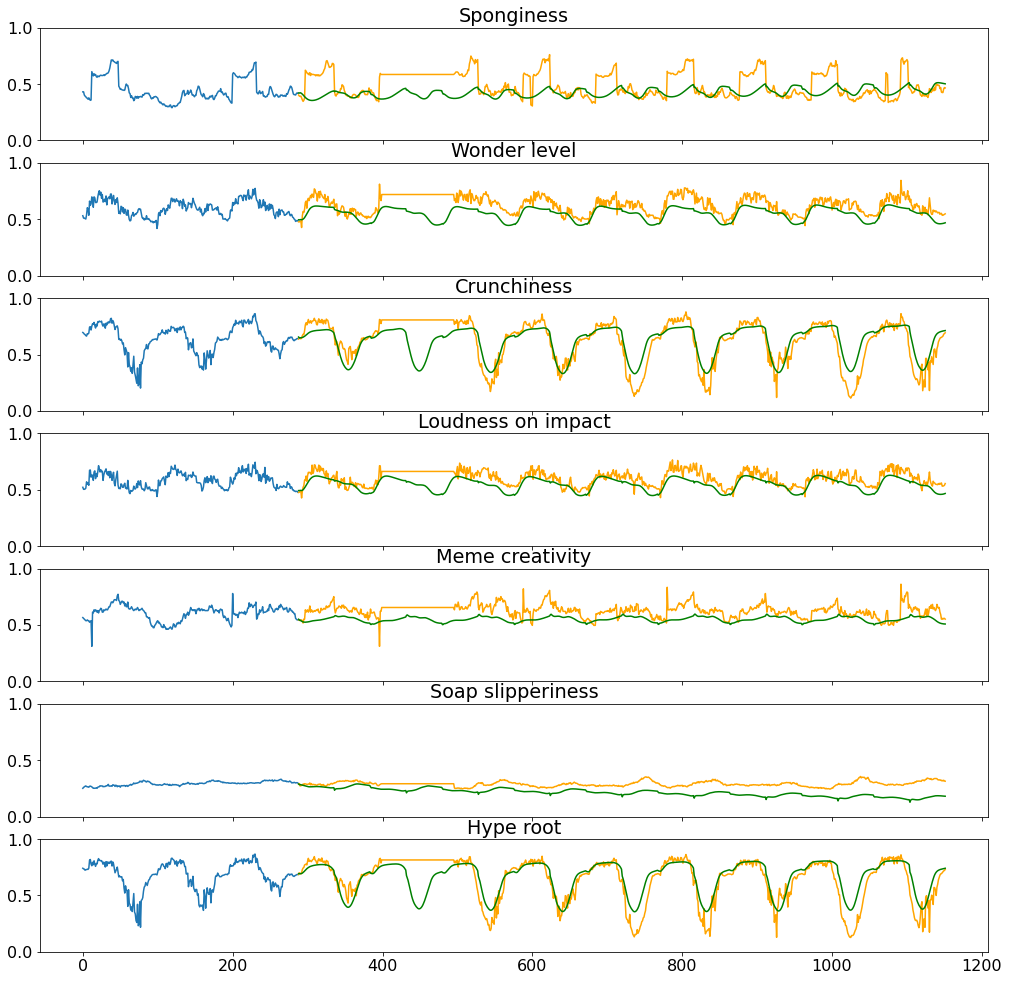

In [25]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, REG_TELESCOPE)

In [ ]:
def build_luo_att_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    #input_layer = tfkl.Input(shape=input_shape, name='Input')

    
    encoder_stack_h, encoder_last_h, encoder_last_c = tfkl.LSTM(
    128, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=True, return_state=True)(input_shape)

    encoder_last_h = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = tfkl.BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder_input = tfkl.RepeatVector(output_train.shape[1])(encoder_last_h)
    decoder_stack_h = tfkl.LSTM(128, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])

    attention = tfkl.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = tfkl.Activation('softmax')(attention)

    context = tfkl.dot([attention, encoder_stack_h], axes=[2,1])
    context = tfkl.BatchNormalization(momentum=0.6)(context)

    decoder_combined_context = tfkl.concatenate([context, decoder_stack_h])

    out = tfkl.TimeDistributed(tfkl.Dense(output_train.shape[2]))(decoder_combined_context)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_train, outputs=out)
    opt = tfk.optimizers.Adam(lr=0.01, clipnorm=1)
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()


    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 7)]     0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 288, 128),   69632       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 128)         512         ['lstm_4[0][1]']                 
 rmalization)                                                                                 

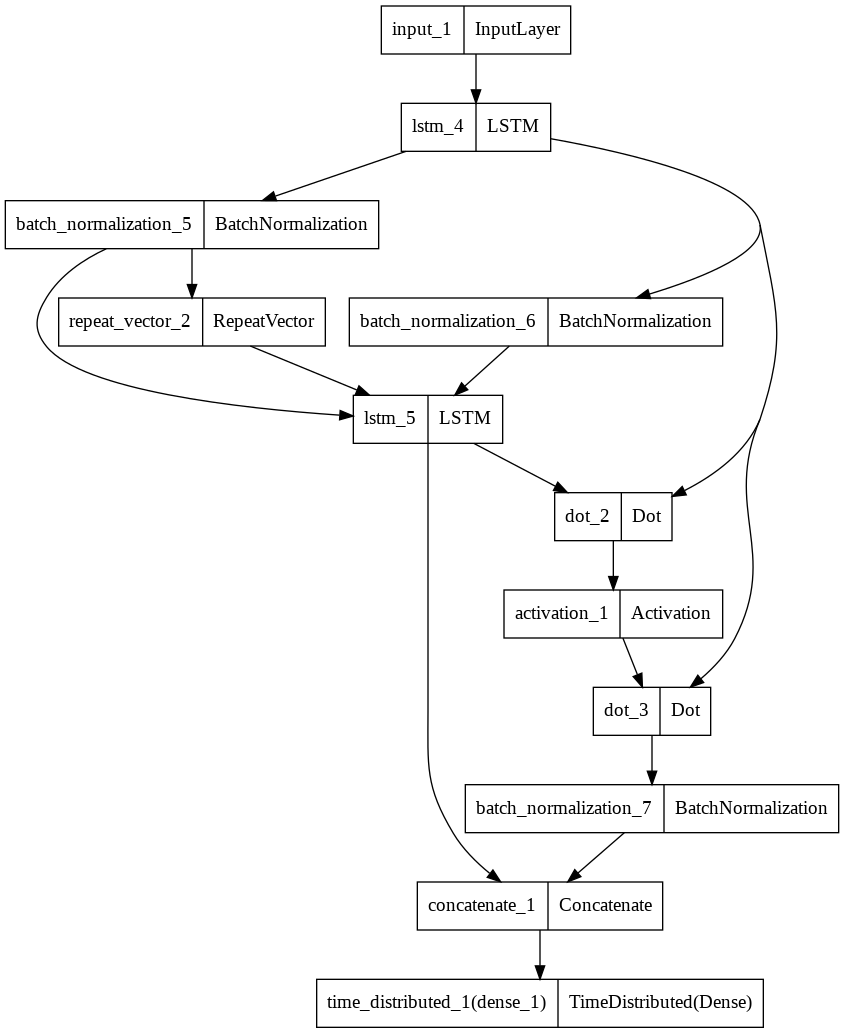

In [ ]:
model = build_luo_att_model(input_train, output_train)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

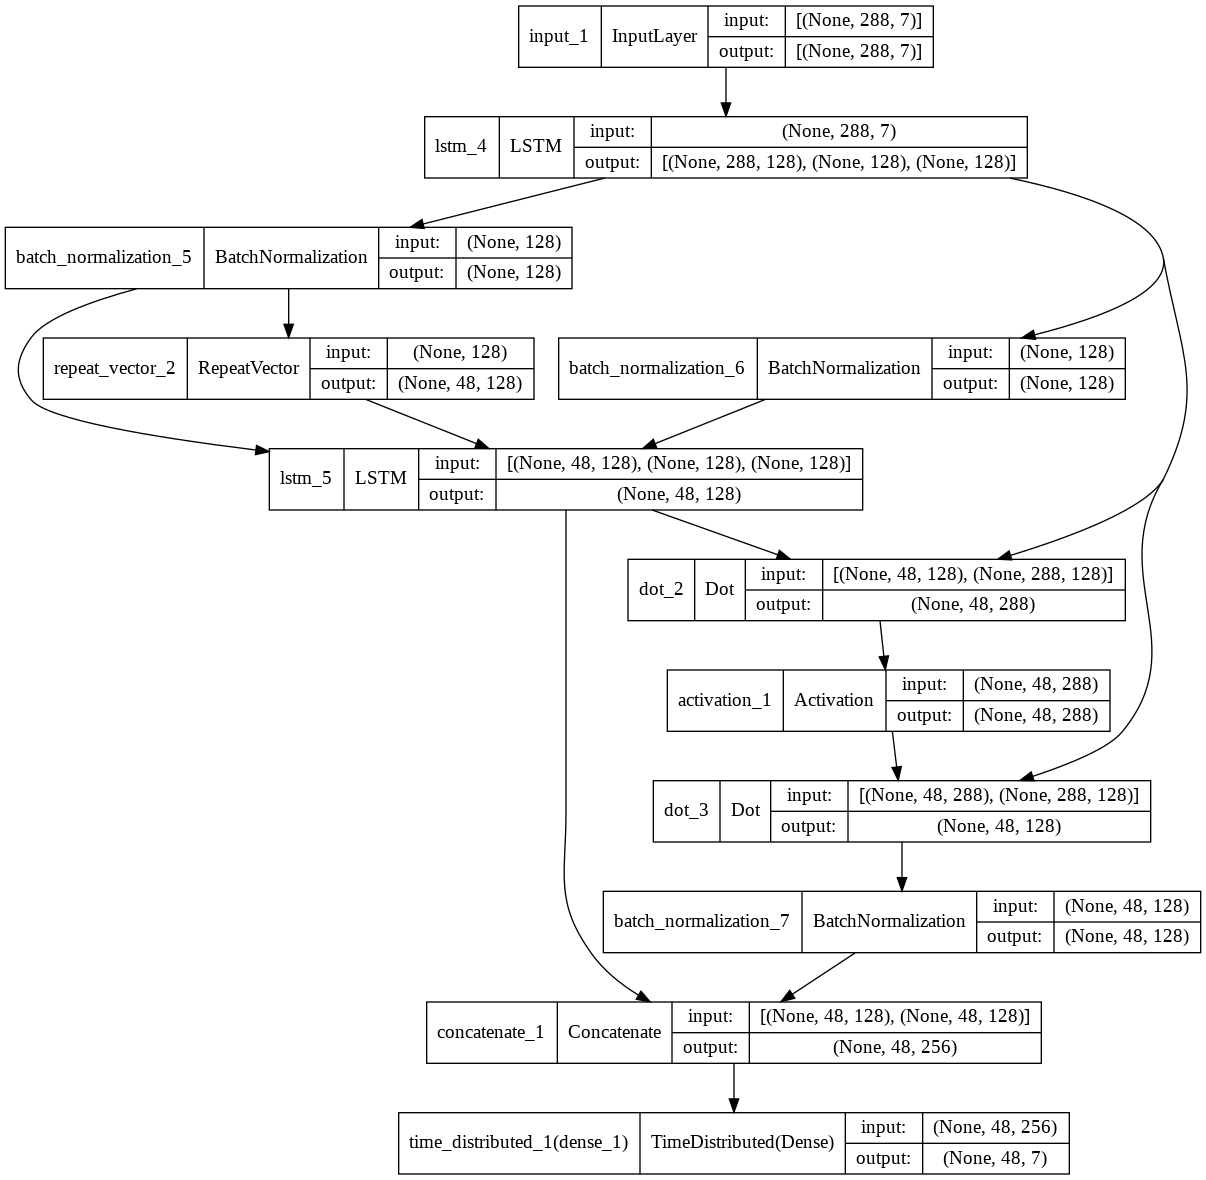

In [ ]:
tfk.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 90,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/90
97/97 [==============================] - 215s 2s/step - loss: 0.0506 - root_mean_squared_error: 0.2248 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367 - lr: 0.0010
Epoch 2/90
97/97 [==============================] - 206s 2s/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154 - lr: 0.0010
Epoch 3/90
97/97 [==============================] - 207s 2s/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177 - lr: 0.0010
Epoch 4/90
97/97 [==============================] - 207s 2s/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195 - lr: 0.0010
Epoch 5/90
97/97 [==============================] - 205s 2s/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1191 - lr: 0.0010
Epoch 6/90
97/97 [==============================] - 198s 2s/step - loss: 0.0090 

In [ ]:
model.save('AuroregressiveLOUGATTForecasting48')

In [26]:
# model.save('AuroregressiveForecasting')
model = tfk.models.load_model('AuroregressiveLOUGATTForecasting48')

In [27]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
root_mean_squared_error = math.sqrt(tfk.metrics.mse(y_test.flatten(),predictions.flatten()))
mean_squared_error, mean_absolute_error, root_mean_squared_error

(731, 48, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0076477802>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.062674634>,
 0.08745158795503243)

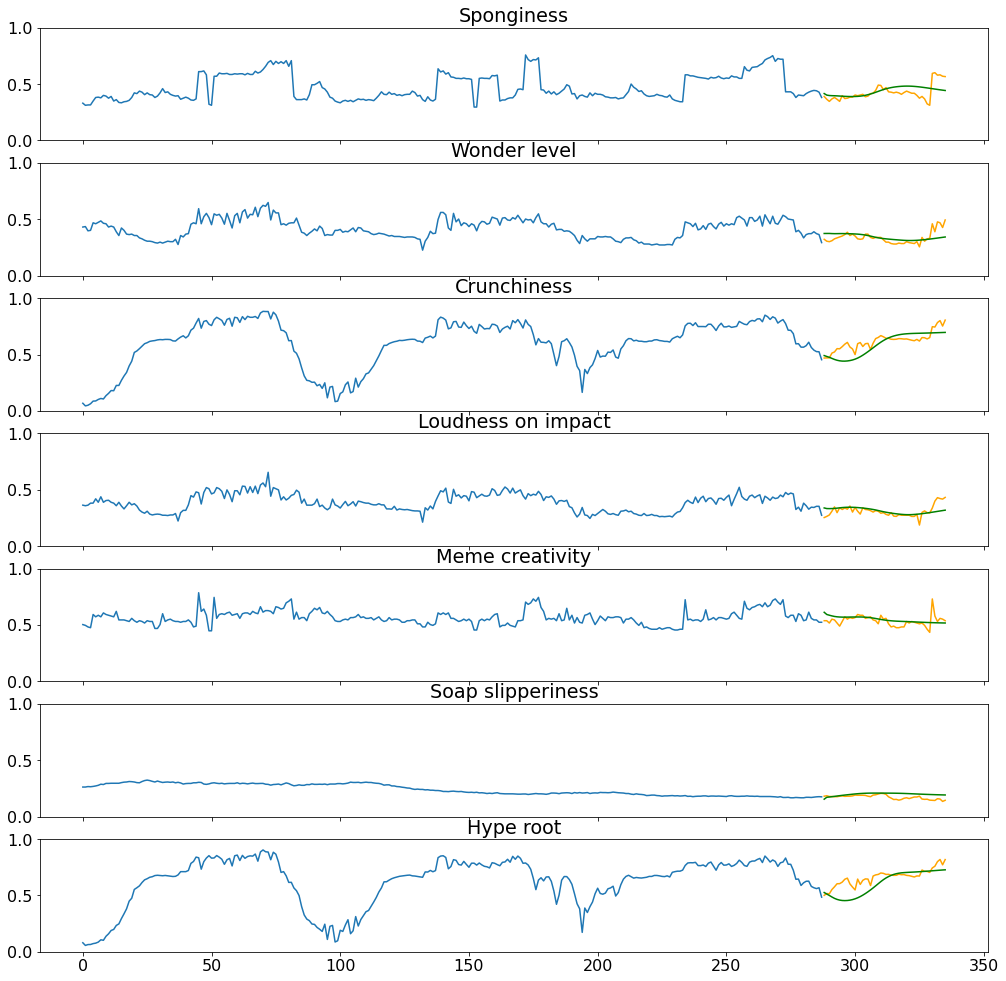

In [28]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, TELESCOPE)

In [29]:
REG_TELESCOPE = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, WINDOWS_LENGTH,TELESCOPE, REG_TELESCOPE)
X_test_reg.shape, y_test_reg.shape

((120, 288, 7), (120, 864, 7))

In [30]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,REG_TELESCOPE,TELESCOPE):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,TELESCOPE:,:],pred_temp), axis=1)

In [31]:
reg_predictions.shape

(120, 864, 7)

In [32]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
root_mean_squared_error = math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.010991456>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07692514>,
 0.10484014492118862)

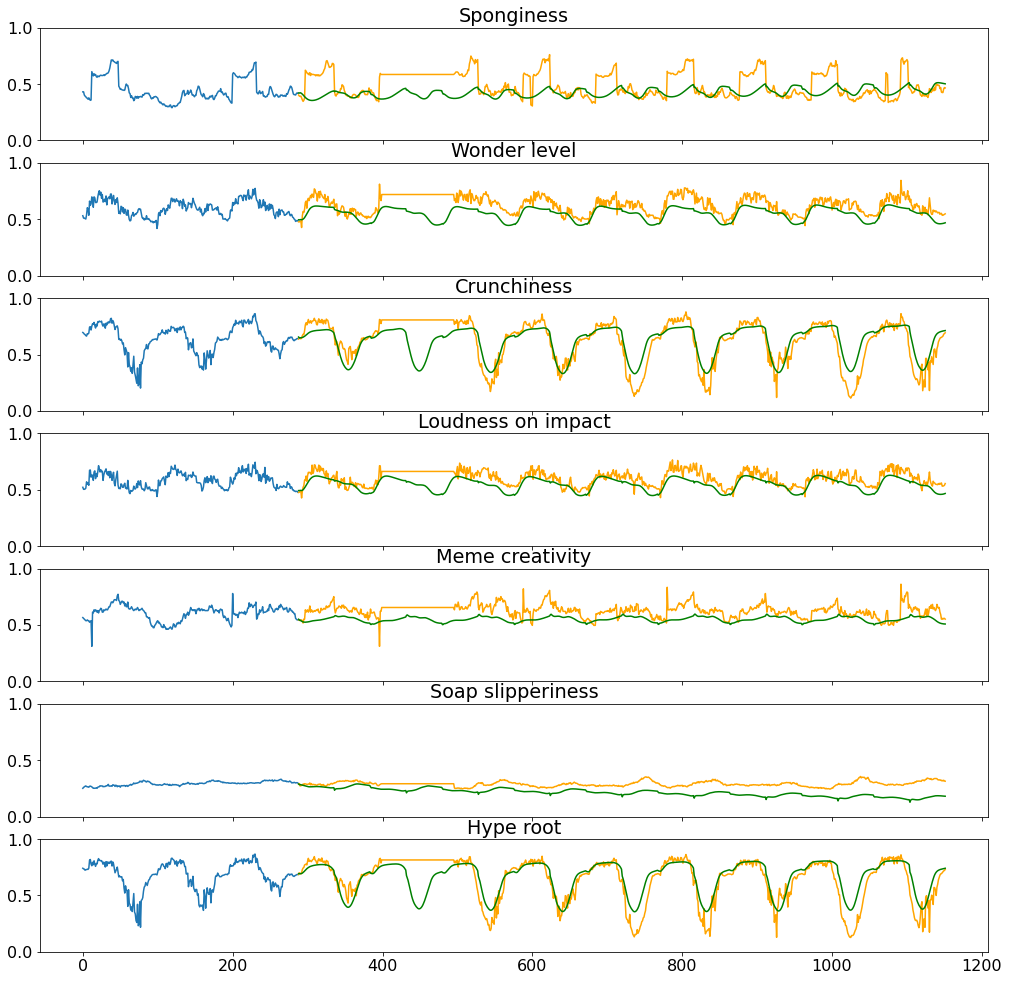

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, REG_TELESCOPE)